# Classification Model

This workbook contains a classification model for predicting whether a customer will accept or not the next campaing.

Disclaimer: For running this code, its necessary to have availabe ''data_modelo.csv' file, which is a product of EDA.ipynb file in the same folder.


Since we are tackling a classification problem with supervised learning, I'll use RandomForest algorithm due to its ease of implementation and resistence to overfitting.

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, classification_report,roc_curve, roc_auc_score, auc

In [54]:
df=pd.read_csv('data_modelo.csv')

# Cost Function & Model Performance

<br>

In order to evaluate our model performance, we gotta connect with business goals: <b>maximize profit of the next campaign.</b>
According to data provided, we can calculate the profit or loss of our correct/incorrect predictions.

<br>

#### Data provided:
<il>
<li>Revenue of a succesful conversion: 11MU</li>
<li>Cost of contact: 3MU  </li>
</il>

<br>

#### Thus, the costs are:
<il>
<li>True Positive: +8MU</li>
<li>False Positive Cost: -3MU  </li>
<li>True Negative Cost: +3MU  </li>
<li>False Negative Cost: -8MU  </li>
</il>


<br>

In other words, a False Negative happens when we miss the chance of profiting 8MU because we wrongly predicted that the customer would not accept the campaign.
This cost is almost 3x higher then a False Positive cost. Thats why <b>we want to to minimize the total amount of False Negatives.</b>
<br>
So, we'll focus on <b>Sensitivity</b> as a performance measure in order to guarantee we are detecting most of the opportunities of profiting.

In [55]:
costs = [[3,-3],[-8,8]]
costs


[[3, -3], [-8, 8]]

# Splitting the Dataset in X & y  (dependent & indepentend variables)

In [56]:
df.dtypes

Unnamed: 0                      int64
Income                        float64
Kidhome                         int64
Teenhome                        int64
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                    int64
AcceptedCmp4                    int64
AcceptedCmp5                    int64
AcceptedCmp1                    int64
AcceptedCmp2                    int64
Complain                        int64
Response                        int64
Age                             int64
Years_as_Customer               int64
Family_Size                     int64
Total_income

In [57]:
X= df.drop(['Response','Unnamed: 0'], axis=1)
y=df['Response']

# Now lets split in train & test Datasets

<br>

We'll use 70% of our data as training data and 30% as testing data

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3, random_state=1)

# Model #1: Creation & Training


I'll use a random_state because I want to this work to be replicable.

In [59]:
randomforest_classifier = RandomForestClassifier(n_estimators=2000, random_state=1)
randomforest_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

# Model #1 : Evaluating

In [60]:
y_predict=randomforest_classifier.predict(X_test)
proba = randomforest_classifier.predict_proba(X_test)
cm= confusion_matrix(y_test, y_predict)

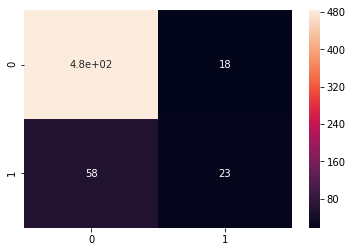

In [61]:
fig1, ax1 = plt.subplots()
ax1 = sns.heatmap(cm, annot=True)

In [62]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       501
           1       0.56      0.28      0.38        81

    accuracy                           0.87       582
   macro avg       0.73      0.62      0.65       582
weighted avg       0.85      0.87      0.85       582



# Model 1: Veredict


<br>


Our first model although has a good Accuracy (87%), it has a really high ammout of False Positives. As we saw, that is the most expensive kind of error we can have in this problem (where we miss the chance of profitting 8MU)

The reason for this is that our dataset is <b>unbalanced</b>. As only ~15% of our data actually accepted the Campaing, the model learns that most of the time people don't accept it.

For fixing this, we'll create our Model 2, with a balanced dataset.
   

# Model 2: Data Balancing

In [63]:
df[df['Response']==1].shape[0]

288

As we can see, we only hace 288 rows with Response = 1. In order to get a 50/50 balanced data, we'll randomlly select 288 rows where Rensponse = 0.

In [64]:
# Shuffle the Dataset.
shuffled_df = df.sample(frac=1,random_state=1)

# Put all the fraud class in a separate dataset.
convert_df = df.loc[shuffled_df['Response'] == 1]



#Randomly select 492 observations from the non-fraud (majority class)
non_convert_df = shuffled_df.loc[shuffled_df['Response'] == 0].sample(n=df[df['Response']==1].shape[0],random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([convert_df, non_convert_df])


normalized_df.groupby(normalized_df.Response).count()

,Unnamed: 0,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Deal_purchases,channels_factor,Basic,Graduation,Master,PhD,Married,Single,Together,Widow
Response,,,,,,,,,,,,,,,,,,,,,
0,288,288,288,288,288,288,288,288,288,288,...,288,288,288,288,288,288,288,288,288,288
1,288,288,288,288,288,288,288,288,288,288,...,288,288,288,288,288,288,288,288,288,288


Now we have a perfect balanced dataset. Lets train or model again with this new data.

# Model 2: Data Split and Training

In [65]:
X= normalized_df.drop(['Response','Unnamed: 0'], axis=1)
y=normalized_df['Response']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3, random_state=1)

randomforest_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

# Model 2: Evaluation

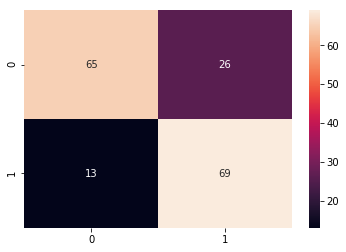

In [66]:
y_predict=randomforest_classifier.predict(X_test)
proba = randomforest_classifier.predict_proba(X_test)
cm= confusion_matrix(y_test, y_predict)

fig1, ax1 = plt.subplots()
ax1 = sns.heatmap(cm, annot=True)


In [67]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77        91
           1       0.73      0.84      0.78        82

    accuracy                           0.77       173
   macro avg       0.78      0.78      0.77       173
weighted avg       0.78      0.77      0.77       173



In [68]:
np.sum((cm*costs))

565

Much better results for our business problem. Now we only miss <b>16%</b> of our customers who would accept the campaing.
The Cost Function sums up to 565MU, which means that we are with a good balance of Errors (financially speaking)

In [69]:
probs = proba[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)

AUC: 0.88


In [70]:
fpr, tpr, thresholds = roc_curve(y_test, probs)

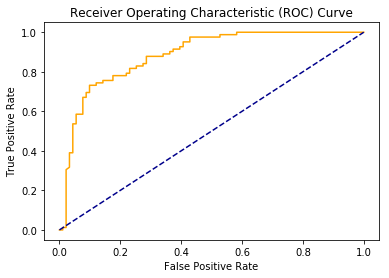

None

In [71]:
def plot_roc_curve(fpr, tpr):
    plt.clf()
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    display(plt.show())

plot_roc_curve(fpr, tpr)

# Model 2: Veredict

Our AUC (Area under Curve) is 0.88 which is decent but has room for improvement. We'll perform some feature selection for our Model 3 focusing specially on Sensitivity.

For this, lets first take a look at the list of features sorted by importances:

In [72]:
feature_importances = pd.DataFrame(randomforest_classifier.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [73]:
print(feature_importances)

                            importance
Recency                       0.069238
channels_factor               0.059368
%StorePurchases               0.058603
%CatalogPurchases             0.035343
MntGoldProds                  0.032397
Total_Conv                    0.032372
Total_income_familymember     0.032095
%Sweet                        0.031803
AOV                           0.029918
Total_spent                   0.029677
%Meat                         0.028305
Total_spent_percent_income    0.027613
RecentCmp                     0.027193
MntMeatProducts               0.025574
MntWines                      0.024978
%Gold                         0.024907
NumWebVisitsMonth             0.024675
Income                        0.023867
MntSweetProducts              0.023795
Years_as_Customer             0.022028
Age                           0.021714
%DealPurchases                0.021499
%Wine                         0.021397
products_factor               0.020664
%Fish                    

# Model 3: Feature Selection


This step involves a lot of experimenting and "feeling" the model while you select the features.

RandomForest models are tricky in terms of feature importances because if two features are highly correlated, one of them will be considere very important while the other will loose importance, and that's not actually the reality.

For this problem, I tried to remove columns with low importance and preferably those which have a high correlation with others in the list.
<br>
<b>Example</b> : Remove AcceptedCmp's (all 5 campaings) because we already created a Total_Conv which brings the information we need.



In [74]:
columns_remove=['Kidhome','Teenhome','AcceptedCmp5','AcceptedCmp4','AcceptedCmp3','AcceptedCmp2','AcceptedCmp1',\
                 'Complain','Deal_purchases','NumDealsPurchases','Widow','Basic','PhD','Together','Graduation','Family_Size',\
               'Total_spent','%Fish','Total_spent','Master','%CatalogPurchases','Total_Purchases','NumWebPurchases',\
                'MntFishProducts','%Sweet','%StorePurchases','MntSweetProducts','Total_income_familymember']

# Model 3: Splitting data and Training Model

In [75]:
X= normalized_df.drop(['Response','Unnamed: 0']+columns_remove, axis=1)
y=normalized_df['Response']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3, random_state=1)

randomforest_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

# Model 3: Evaluating

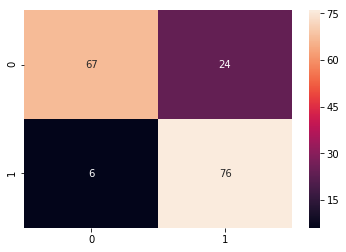

In [76]:
y_predict=randomforest_classifier.predict(X_test)
proba = randomforest_classifier.predict_proba(X_test)
cm= confusion_matrix(y_test, y_predict)

fig1, ax1 = plt.subplots()
ax1 = sns.heatmap(cm, annot=True)

In [77]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82        91
           1       0.76      0.93      0.84        82

    accuracy                           0.83       173
   macro avg       0.84      0.83      0.83       173
weighted avg       0.84      0.83      0.83       173



In [78]:
probs = proba[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)

AUC: 0.90


Our model had a big improvement by removing features. That means that it was overfitted. In other words, it was learning too well our training data and having a hard time "generalizing" this knowledge to predict others datasets.

Now we only miss 7% of our possibles convertions.

Lets take a look in our selected features:

In [79]:
feature_importances = pd.DataFrame(randomforest_classifier.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

print(feature_importances)

                            importance
channels_factor               0.100761
Recency                       0.094969
MntGoldProds                  0.049910
AOV                           0.045692
Total_Conv                    0.044329
%Meat                         0.043711
RecentCmp                     0.043494
MntMeatProducts               0.043080
Total_spent_percent_income    0.042888
MntWines                      0.038732
%Gold                         0.037156
Income                        0.036772
Age                           0.033634
%Wine                         0.031690
Total_Purchases_year          0.031507
NumWebVisitsMonth             0.031136
products_factor               0.031109
%DealPurchases                0.030981
Years_as_Customer             0.030426
%WebPurchases                 0.029606
%Fruit                        0.029051
NumCatalogPurchases           0.026781
NumStorePurchases             0.024366
MntFruits                     0.023383
Single                   

In [80]:
feature_importances

,importance
channels_factor,0.100761
Recency,0.094969
MntGoldProds,0.049910
AOV,0.045692
Total_Conv,0.044329
%Meat,0.043711
RecentCmp,0.043494
MntMeatProducts,0.043080
Total_spent_percent_income,0.042888
MntWines,0.038732


Turned out that channels_factor, Recency, AOV & MntGoldProds are the most important features for this model.

# Model 3: Cost Function

In [81]:
np.sum((cm*costs))

689

After feature selection, we now have n Net revenue of 689MU (22% improvement versus Model 2).
Bellow we have net values for each type of error

In [82]:
(cm*costs)

array([[201, -72],
       [-48, 608]], dtype=int64)

# Conslusions

<br>

<il>
<li>We developed a model with 93% Sensititivy (or recall) for Conversions.
That means we loose 7% of our opportunities of conversions for miss-predicting the behavior of that customer.</li>
<li>Focusing on this metric was a decision due to business costs of False Negatives/Positives that were provided in the case. Besides that AUC is 0.9 and Accuracy 0.83</li>
<li>The mains improvements from Model 1 & 2 came from dataset balancing and feature selection.</li>
</il>

# Suggestion of Future Improvements

<br>

<il>
<li>To gather more good data for modelling customer behavior.Ex.: Region where they live, Dates of purchases/acceptance, website visits & Num WebPurchases from the same timeframe etc </li>
<li>Work with normalization and creation of new features</li>
<li> To work in data skewness;</li>
<li> Try others undersampling (or oversampling) techniques;</li>
<li> Try more sofisticated tecniques for outliers detection.</li>
</il>

